# Basic CNN


## Description

**Codabench accuracy** : 0.22

**Local test accuracy**: 0.94

**Description**: a simple custom Convolutional Neural Network

**Motivation**: prove that even a simple CNN is capable of obtaining a good performance on the available data. The submission preformance is really low even in this case, we expect the data that is being used on codabench to be really different with respect to the one provided to us.

## Google Drive - Connecting to the project

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1"
%cd {project_path}
sys.path.append(project_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1CRSDpvo8yN6Wc7UchdjWSs6h8RroV7e4/le acque del friuli - Homework 1


## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import utils

import numpy as np
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [ ]:
# We are dealing with an 8-class problem with 96x96 RGB images as input
OUTPUT_SIZE = 8
INPUT_SHAPE = (96,96,3)

## Load Data

In [ ]:
# Cleaned dataset loading with a split in three datasets: training, validation, and test
X, y = utils.load_cleaned_dataset()
X_train, X_val, X_test, y_train, y_val, y_test = utils.split_dataset(X, y, test_size=0.2, val_size=0.2)

## Model Implementation

In [ ]:
# Parameter to define the probability of drop out of a neuron
DROPOUT_RATE = 0.4

In [ ]:
# Definition of the model
def build_model():
    # The input layer takes 96x96 RGB images
    input_layer = tfkl.Input(shape=INPUT_SHAPE, name='Input')

    # Convolutional layers and max pooling layers with ReLU activation functions and small kernel size
    x = tfkl.Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='Conv2D_1')(input_layer)
    x = tfkl.MaxPooling2D(pool_size=(2,2), name='MaxPooling2D_1')(x)
    x = tfkl.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='Conv2D_2')(x)
    x = tfkl.MaxPooling2D(pool_size=(2,2), name='MaxPooling2D_2')(x)
    x = tfkl.Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='Conv2D_3')(x)
    x = tfkl.MaxPooling2D(pool_size=(2,2), name='MaxPooling2D_3')(x)

    # Flattening layer for vectorization
    x = tfkl.Flatten(name='Flatten')(x)

    # Dropout layer used for regularization
    x = tfkl.Dropout(rate=DROPOUT_RATE, name='Dropout')(x)

    # Dense layer as output
    output_layer = tfkl.Dense(OUTPUT_SIZE, activation='softmax', name='Output')(x)
    model = tfk.Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
# Model contruction
model = build_model()

# Model compilation with Adam as optimizer and sparse categorical crossentropy as loss function
model.compile(optimizer=tfk.optimizers.Adam(),
              loss=tfk.losses.SparseCategoricalCrossentropy(), #Sparse since we are not one-hot-encoding (no difference)
              metrics=['accuracy'])

# Print model details
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_1 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_1 (MaxPooling2D)        │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_2 (MaxPooling2D)        │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_3 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_3 (MaxPooling2D)        │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout (Dropout)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 8)                   │         102,408 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 195,656 (764.28 KB)

 Trainable params: 195,656 (764.28 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [ ]:
# Parameters used for training
EPOCHS = 1000
BATCH_SIZE = 32
PATIENCE = 10

In [ ]:
# Implementation of early stopping as a technique to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)
callbacks = [early_stopping]

In [ ]:
# Actual training of the model with the given parameters
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    validation_data=(X_val,y_val)).history

Epoch 1/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.4417 - loss: 8.3809 - val_accuracy: 0.8006 - val_loss: 0.6181
Epoch 2/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7628 - loss: 0.6780 - val_accuracy: 0.8303 - val_loss: 0.5022
Epoch 3/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8351 - loss: 0.4705 - val_accuracy: 0.8984 - val_loss: 0.3376
Epoch 4/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8525 - loss: 0.4004 - val_accuracy: 0.8495 - val_loss: 0.4196
Epoch 5/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8764 - loss: 0.3496 - val_accuracy: 0.8650 - val_loss: 0.4017
Epoch 6/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8998 - loss: 0.2740 - val_accuracy: 0.9026 - val_loss: 0.2731
Epoch 7/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8913 - loss: 0.2856 - val_accuracy: 0.9143 - val_loss: 0.2629
Epoch 8/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9205 - loss: 0.23

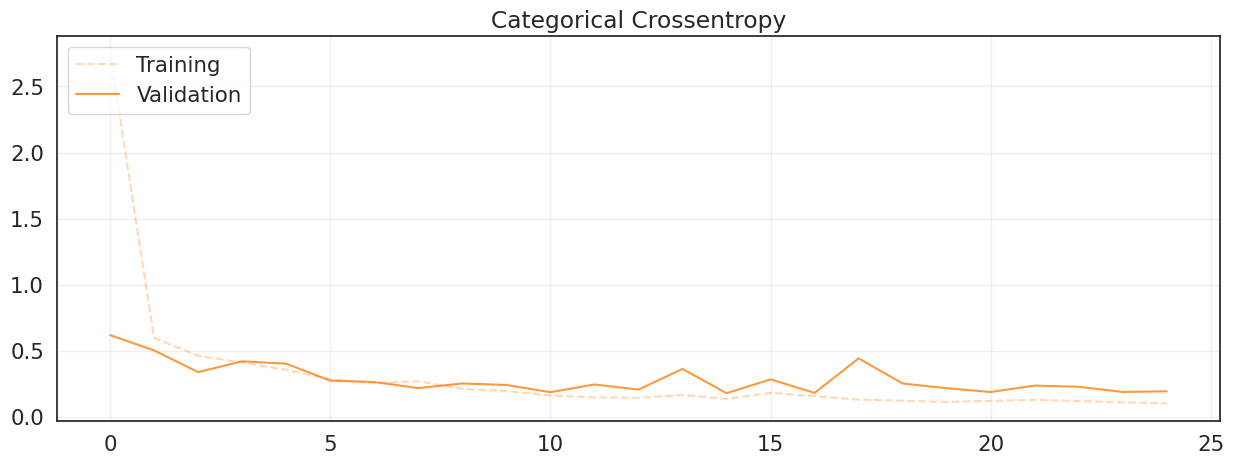

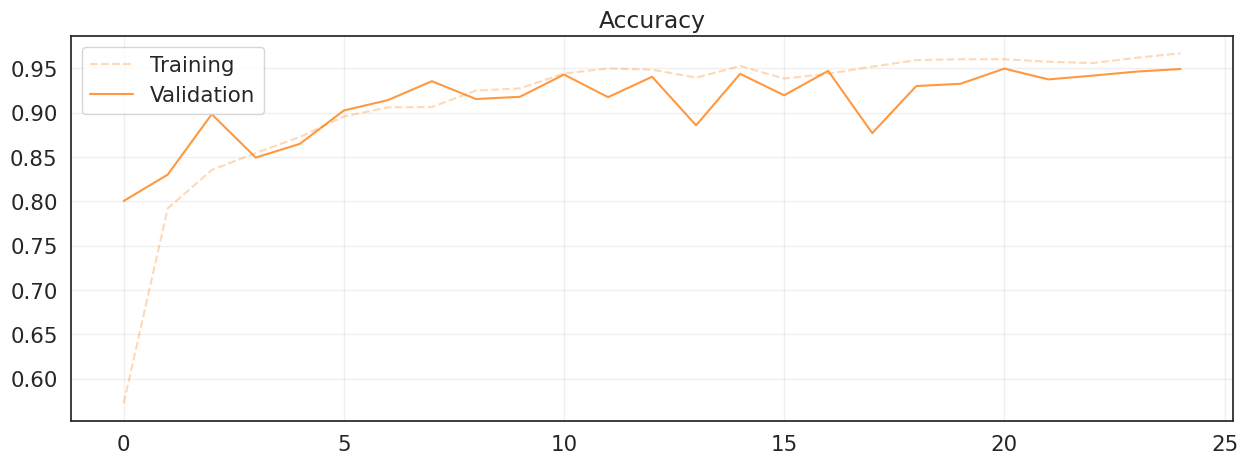

In [ ]:
# Plot the loss function and accuracy value over epochs
utils.plot_history(history)

## Save

In [ ]:
# Saving the model for testing and submission
accuracy = round(max(history['val_accuracy'])* 100, 2)
model_name = f"custom_cnn_{accuracy}.keras"
%cd models/
print(f"Saving {model_name}")
model.save(model_name)
%cd ..
print("Model Saved")

/content/drive/.shortcut-targets-by-id/1CRSDpvo8yN6Wc7UchdjWSs6h8RroV7e4/le acque del friuli - Homework 1/models
Saving custom_cnn_94.98.keras
/content/drive/.shortcut-targets-by-id/1CRSDpvo8yN6Wc7UchdjWSs6h8RroV7e4/le acque del friuli - Homework 1
Model Saved


## Test Prediction and Final Evaluation

In [ ]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=1)

In [ ]:
# Calculate and display test set accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(y_test, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(y_test, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(y_test, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

Accuracy score over the test set: 0.9356
Precision score over the test set: 0.9371
Recall score over the test set: 0.9356
F1 score over the test set: 0.9356
